In [348]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
import matplotlib.pyplot as plt
import seaborn as sns


pd.set_option('display.max_columns', None)

seed = 9

df = pd.read_csv('rental_info.csv', parse_dates=['return_date', 'rental_date'])
print(df.head())

                rental_date               return_date  amount  release_year  \
0 2005-05-25 02:54:33+00:00 2005-05-28 23:40:33+00:00    2.99        2005.0   
1 2005-06-15 23:19:16+00:00 2005-06-18 19:24:16+00:00    2.99        2005.0   
2 2005-07-10 04:27:45+00:00 2005-07-17 10:11:45+00:00    2.99        2005.0   
3 2005-07-31 12:06:41+00:00 2005-08-02 14:30:41+00:00    2.99        2005.0   
4 2005-08-19 12:30:04+00:00 2005-08-23 13:35:04+00:00    2.99        2005.0   

   rental_rate  length  replacement_cost                special_features  \
0         2.99   126.0             16.99  {Trailers,"Behind the Scenes"}   
1         2.99   126.0             16.99  {Trailers,"Behind the Scenes"}   
2         2.99   126.0             16.99  {Trailers,"Behind the Scenes"}   
3         2.99   126.0             16.99  {Trailers,"Behind the Scenes"}   
4         2.99   126.0             16.99  {Trailers,"Behind the Scenes"}   

   NC-17  PG  PG-13  R  amount_2  length_2  rental_rate_2  
0      0

Explore the dataframe, checking for any missing data, identifying outliers, and printing summary statistics.

In [349]:
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15861 entries, 0 to 15860
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype              
---  ------            --------------  -----              
 0   rental_date       15861 non-null  datetime64[ns, UTC]
 1   return_date       15861 non-null  datetime64[ns, UTC]
 2   amount            15861 non-null  float64            
 3   release_year      15861 non-null  float64            
 4   rental_rate       15861 non-null  float64            
 5   length            15861 non-null  float64            
 6   replacement_cost  15861 non-null  float64            
 7   special_features  15861 non-null  object             
 8   NC-17             15861 non-null  int64              
 9   PG                15861 non-null  int64              
 10  PG-13             15861 non-null  int64              
 11  R                 15861 non-null  int64              
 12  amount_2          15861 non-null  float64            
 13  l

There is no missing data. The amount_2 column has an outlying value, but considering that this column is just the amount attribute squared, it is reasonable that this large value is not illegitimate. Observing the max value of the Amount column, it does not appear to be an outlier.

Also, we'll note that special_features is the only object data type.

First, create the needed rental_length_days column by taking the difference of the return_date and rental_date.

In [350]:
df['rental_length_days'] = (df['return_date'] - df['rental_date']).dt.days
print(df.head())

                rental_date               return_date  amount  release_year  \
0 2005-05-25 02:54:33+00:00 2005-05-28 23:40:33+00:00    2.99        2005.0   
1 2005-06-15 23:19:16+00:00 2005-06-18 19:24:16+00:00    2.99        2005.0   
2 2005-07-10 04:27:45+00:00 2005-07-17 10:11:45+00:00    2.99        2005.0   
3 2005-07-31 12:06:41+00:00 2005-08-02 14:30:41+00:00    2.99        2005.0   
4 2005-08-19 12:30:04+00:00 2005-08-23 13:35:04+00:00    2.99        2005.0   

   rental_rate  length  replacement_cost                special_features  \
0         2.99   126.0             16.99  {Trailers,"Behind the Scenes"}   
1         2.99   126.0             16.99  {Trailers,"Behind the Scenes"}   
2         2.99   126.0             16.99  {Trailers,"Behind the Scenes"}   
3         2.99   126.0             16.99  {Trailers,"Behind the Scenes"}   
4         2.99   126.0             16.99  {Trailers,"Behind the Scenes"}   

   NC-17  PG  PG-13  R  amount_2  length_2  rental_rate_2  rental_le

Now, let's explore the special_features attribute.

In [351]:
print(df['special_features'].value_counts())

{Trailers,Commentaries,"Behind the Scenes"}                     1308
{Trailers}                                                      1139
{Trailers,Commentaries}                                         1129
{Trailers,"Behind the Scenes"}                                  1122
{"Behind the Scenes"}                                           1108
{Commentaries,"Deleted Scenes","Behind the Scenes"}             1101
{Commentaries}                                                  1089
{Commentaries,"Behind the Scenes"}                              1078
{Trailers,"Deleted Scenes"}                                     1047
{"Deleted Scenes","Behind the Scenes"}                          1035
{"Deleted Scenes"}                                              1023
{Commentaries,"Deleted Scenes"}                                 1011
{Trailers,Commentaries,"Deleted Scenes","Behind the Scenes"}     983
{Trailers,Commentaries,"Deleted Scenes"}                         916
{Trailers,"Deleted Scenes","Behind

Per the task instructions, we are to create two columns of dummy variables which take a value of 1 when the value is "Deleted Scenes" or the value is "Behind the Scenes." Since it appears that special_features contains a comma separated list of features, we are simply looking for movies that contain one of these two strings.

In [352]:
df['deleted_scenes'] = np.where(df['special_features'].str.contains('Deleted Scenes'), 1, 0)
df['behind_the_scenes'] = np.where(df['special_features'].str.contains('Behind the Scenes'), 1, 0)
print(df.head())

                rental_date               return_date  amount  release_year  \
0 2005-05-25 02:54:33+00:00 2005-05-28 23:40:33+00:00    2.99        2005.0   
1 2005-06-15 23:19:16+00:00 2005-06-18 19:24:16+00:00    2.99        2005.0   
2 2005-07-10 04:27:45+00:00 2005-07-17 10:11:45+00:00    2.99        2005.0   
3 2005-07-31 12:06:41+00:00 2005-08-02 14:30:41+00:00    2.99        2005.0   
4 2005-08-19 12:30:04+00:00 2005-08-23 13:35:04+00:00    2.99        2005.0   

   rental_rate  length  replacement_cost                special_features  \
0         2.99   126.0             16.99  {Trailers,"Behind the Scenes"}   
1         2.99   126.0             16.99  {Trailers,"Behind the Scenes"}   
2         2.99   126.0             16.99  {Trailers,"Behind the Scenes"}   
3         2.99   126.0             16.99  {Trailers,"Behind the Scenes"}   
4         2.99   126.0             16.99  {Trailers,"Behind the Scenes"}   

   NC-17  PG  PG-13  R  amount_2  length_2  rental_rate_2  rental_le

Although the instructions are specific and the data is in good condition, we can still explore the data visually to better understand its distributions and relationships.

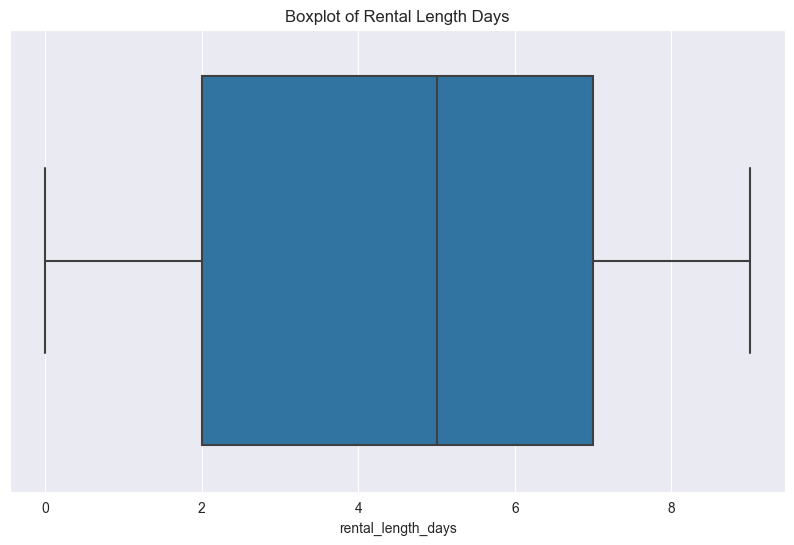

In [353]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['rental_length_days'])
plt.title('Boxplot of Rental Length Days')
plt.show()

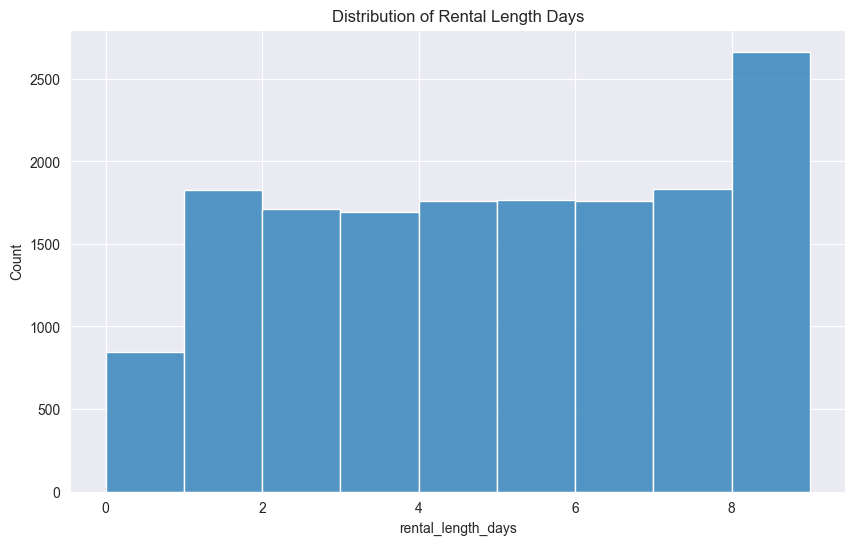

In [354]:
plt.figure(figsize=(10, 6))
sns.histplot(df['rental_length_days'], binwidth=1)
plt.title('Distribution of Rental Length Days')
plt.show()

C:\Users\Mikey\AppData\Local\Temp\ipykernel_284376\3737861028.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=True, cmap='coolwarm')


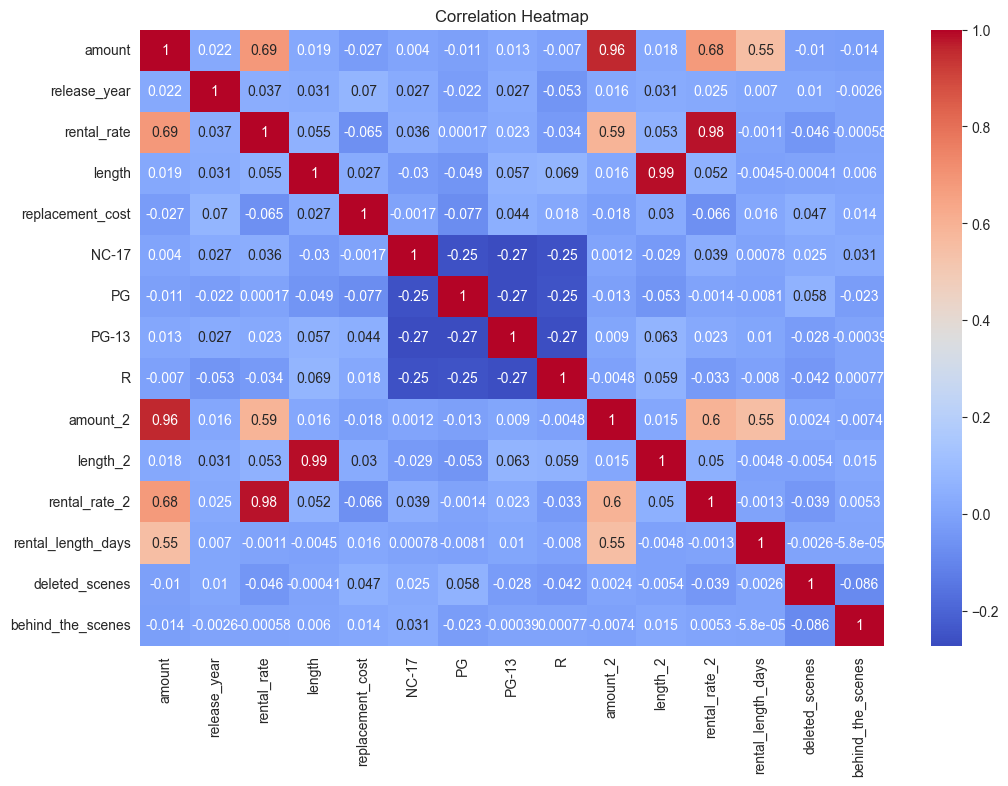

In [355]:
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

One notable issue is the multicollinearity of amount, length, and rental_rate, and their squared variations. It is unclear why both are included, so I removed them from the model to prevent overfitting.

Now we can remove unnecessary columns from the feature list, set up our dependent and independent variables, and split the data set for our modeling.

In [356]:
X = df.drop(columns=['rental_date', 'return_date', 'rental_length_days', 'special_features', 'rental_rate_2', 'amount_2', 'length_2'])
y = df['rental_length_days']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

Next, we'll instantiate the regressor models and their parameter grid for cross validation and hyperparameter tuning. We'll be using Linear Regression, Ridge, Lasso, and Decision Tree Regressor models.

In [357]:
models = {
    'Linear Regression': (LinearRegression(), [{'regressor': [LinearRegression()]}]),
    'Ridge': (Ridge(), [{'regressor': [Ridge()], 'regressor__alpha': np.logspace(-3, 3, 7)}]),
    'Lasso': (Lasso(), [{'regressor': [Lasso()], 'regressor__alpha': np.logspace(-3, 3, 7)}]),
    'Decision Tree Regressor': (DecisionTreeRegressor(), [
        {
            'regressor': [DecisionTreeRegressor()],
            'regressor__max_depth': [None, 10, 20, 30, 40, 50],
            'regressor__min_samples_leaf': [1, 2, 5, 10, 20, 0.05, 0.1, 0.2, 0.25],
            'regressor__max_features': [None, 'sqrt', 'log2', 0.2, 0.5, 0.8]
        }
    ])
}

We'll create an empty dictionary to store the model results before looping through each model using a pipeline. The pipeline will include scaling since the attribute values are significantly different in scale. We'll also use GridSearchCV for cross validation using 5 folds.

Since our goal is to yield an MSE less than 3 on the test set, we'll use the neg_mean_squared_error as our scoring metric.

In [358]:
best_models = {}

for model_name, (model, param_grid) in models.items():
    steps = [
        ('scaler', StandardScaler()),
        ('regressor', model)
    ]
    pipeline = Pipeline(steps)

    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    best_models[model_name] = {
        'best_estimator': grid_search.best_estimator_,
        'best_params': grid_search.best_params_,
        'best_score': -grid_search.best_score_
    }
    print(f"{model_name}: Best Parameters: {grid_search.best_params_}, Best CV Score: {grid_search.best_score_}")

Linear Regression: Best Parameters: {'regressor': LinearRegression()}, Best CV Score: -2.911274482774465
Ridge: Best Parameters: {'regressor': Ridge(), 'regressor__alpha': 1.0}, Best CV Score: -2.911272795304499
Lasso: Best Parameters: {'regressor': Lasso(alpha=0.001), 'regressor__alpha': 0.001}, Best CV Score: -2.91116093925413
Decision Tree Regressor: Best Parameters: {'regressor': DecisionTreeRegressor(max_features=0.5), 'regressor__max_depth': None, 'regressor__max_features': 0.5, 'regressor__min_samples_leaf': 1}, Best CV Score: -2.2310951115365514


Now we'll use our dictionary to find the best scoring model and its MSE before using it on the test set.

In [359]:
best_model_name = min(best_models, key=lambda k: best_models[k]['best_score'])
best_model_info = best_models[best_model_name]
best_mse = best_model_info['best_score']
best_model = best_model_info['best_estimator']
print(f'Best model: {best_model_name}')
print(f'Best MSE: {best_mse}')

Best model: Decision Tree Regressor
Best MSE: 2.2310951115365514


The MSE of the Decision Tree Regressor model is below 3 on the training set, which is a great sign.

Finally, we'll use our model on the test set.

In [360]:
new_model = best_model
new_model.fit(X_train, y_train)
y_pred = new_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Test MSE: {mse}')
print(f'Test R2: {r2}')
print('Best Parameters', best_model_info['best_params'])

Test MSE: 2.1070433997700557
Test R2: 0.7032153717399321
Best Parameters {'regressor': DecisionTreeRegressor(max_features=0.5), 'regressor__max_depth': None, 'regressor__max_features': 0.5, 'regressor__min_samples_leaf': 1}


Since the best model is the Decision Tree Regressor, we are not able to observe the coefficients. However, we can display the feature importance.

In [361]:
# Extract and display feature importances if the best model is a DecisionTreeRegressor
if isinstance(best_model.named_steps['regressor'], DecisionTreeRegressor):
    feature_importances = best_model.named_steps['regressor'].feature_importances_
    feature_names = X.columns
    importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

    # Sort the feature importances in descending order
    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    # Plot feature importances
    """plt.figure(figsize=(10, 6))
    sns.barplot(data=importance_df, x='Importance', y='Feature')
    plt.title('Feature Importances in Decision Tree Regressor')
    plt.savefig('feature_importances.png')
    plt.show()
    """

    # Print the chosen hyperparameters
    print("Chosen Hyperparameters:", best_model_info['best_params'])
else:
    print("The best model is not a DecisionTreeRegressor.")

Chosen Hyperparameters: {'regressor': DecisionTreeRegressor(max_features=0.5), 'regressor__max_depth': None, 'regressor__max_features': 0.5, 'regressor__min_samples_leaf': 1}


![Feature Importances](feature_importances.png)

## Results
The best model for predicting movie rental durations is a Decision Tree Regression model, which produced an MSE of 2.12 on the test set, beneath the required threshold of 3. This model explains 70.1% of variance in movie durations. The Amount attribute is the most important feature in the dataset by far, with rental_rate and length trailing behind.